In [1]:
import sys
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

# Local
cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
sys.path.append(str(src))

from models.mlp import MLP
from utils.watertopo import WaterTopo
from utils.utils import count_parameters, get_corner
from utils.train import train_and_validate, train_test_split

In [2]:
#initialize GPU -  In case of windows use cuda instead of nps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA enabled?",torch.cuda.is_available())
print("Number of GPUs",torch.cuda.device_count())

Is CUDA enabled? False
Number of GPUs 0


In [3]:
model = MLP(2, 256, 1).to(device)

print(f"MLP --> num. trainable parameters:{count_parameters(model):8d}")

MLP --> num. trainable parameters:  264193


In [10]:
sim_amount = 80
use_augmented_data = True

grid_size = 64
channels = 2

training_size = 0.8
batch_size = 20
num_epochs = 100
lr = 0.005
criterion = nn.MSELoss()
optimizer = optim.AdamW
model_name = "mlp_corners_aug_data"

# defining the save path
save_path = "../results/trained_models/mlp/" + model_name

In [11]:
train = False

In [13]:
if train: 
    sims = WaterTopo.load_simulations(str(root)+"/data/normalized_data/tra_val", 
                                      sim_amount=sim_amount, 
                                      number_grids=64, 
                                      use_augmented_data=use_augmented_data)
    # reformat the data
    X = np.zeros((len(sims), grid_size, grid_size, channels))   # timestep * grid_x * grid_y * channels
    Y = np.zeros([*X[:,:,:,0].shape, 1])   # timestep * grid_x * grid_y


    for i in range(len(sims)):   # number of simulations loaded in for training/validation

        sim = sims[i]            # get simulation
        topography = sim.topography

        X[i,:,:,0] = get_corner(sim.wd[0])
        X[i,:,:,1] = topography

        wd = sim.return_timestep(-1)
        Y[i,:,:,0] = wd

    # X = X.reshape(len(sims), channels, grid_size, grid_size)
    # Y = Y.reshape(len(sims), channels-1, grid_size, grid_size)


    # We keep track of indexes of train and validation.
    X_tra, X_tst, Y_tra, Y_tst, ix_tra, ix_tst = train_test_split(
        X, Y, np.arange(X.shape[0]), test_size=1-training_size, shuffle=True, random_state=42)

    # Split the existing test dataset into validation and test sets (50/50 split)
    X_val, X_tst, Y_val, Y_tst, ix_val, ix_tst = train_test_split(
        X_tst, Y_tst, ix_tst, test_size=0.5, shuffle=True, random_state=42)

    #create datasets and data loaders
    train_dataset = TensorDataset(torch.tensor(X_tra, dtype=torch.float32), torch.tensor(Y_tra, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # defining the optimizer
    optimizer = optimizer(model.parameters(), lr=lr)

    # training
    train_losses, val_losses, best_val_loss, time = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path)

# Load the best model
model.load_state_dict(torch.load(save_path, map_location="cpu"))

<All keys matched successfully>

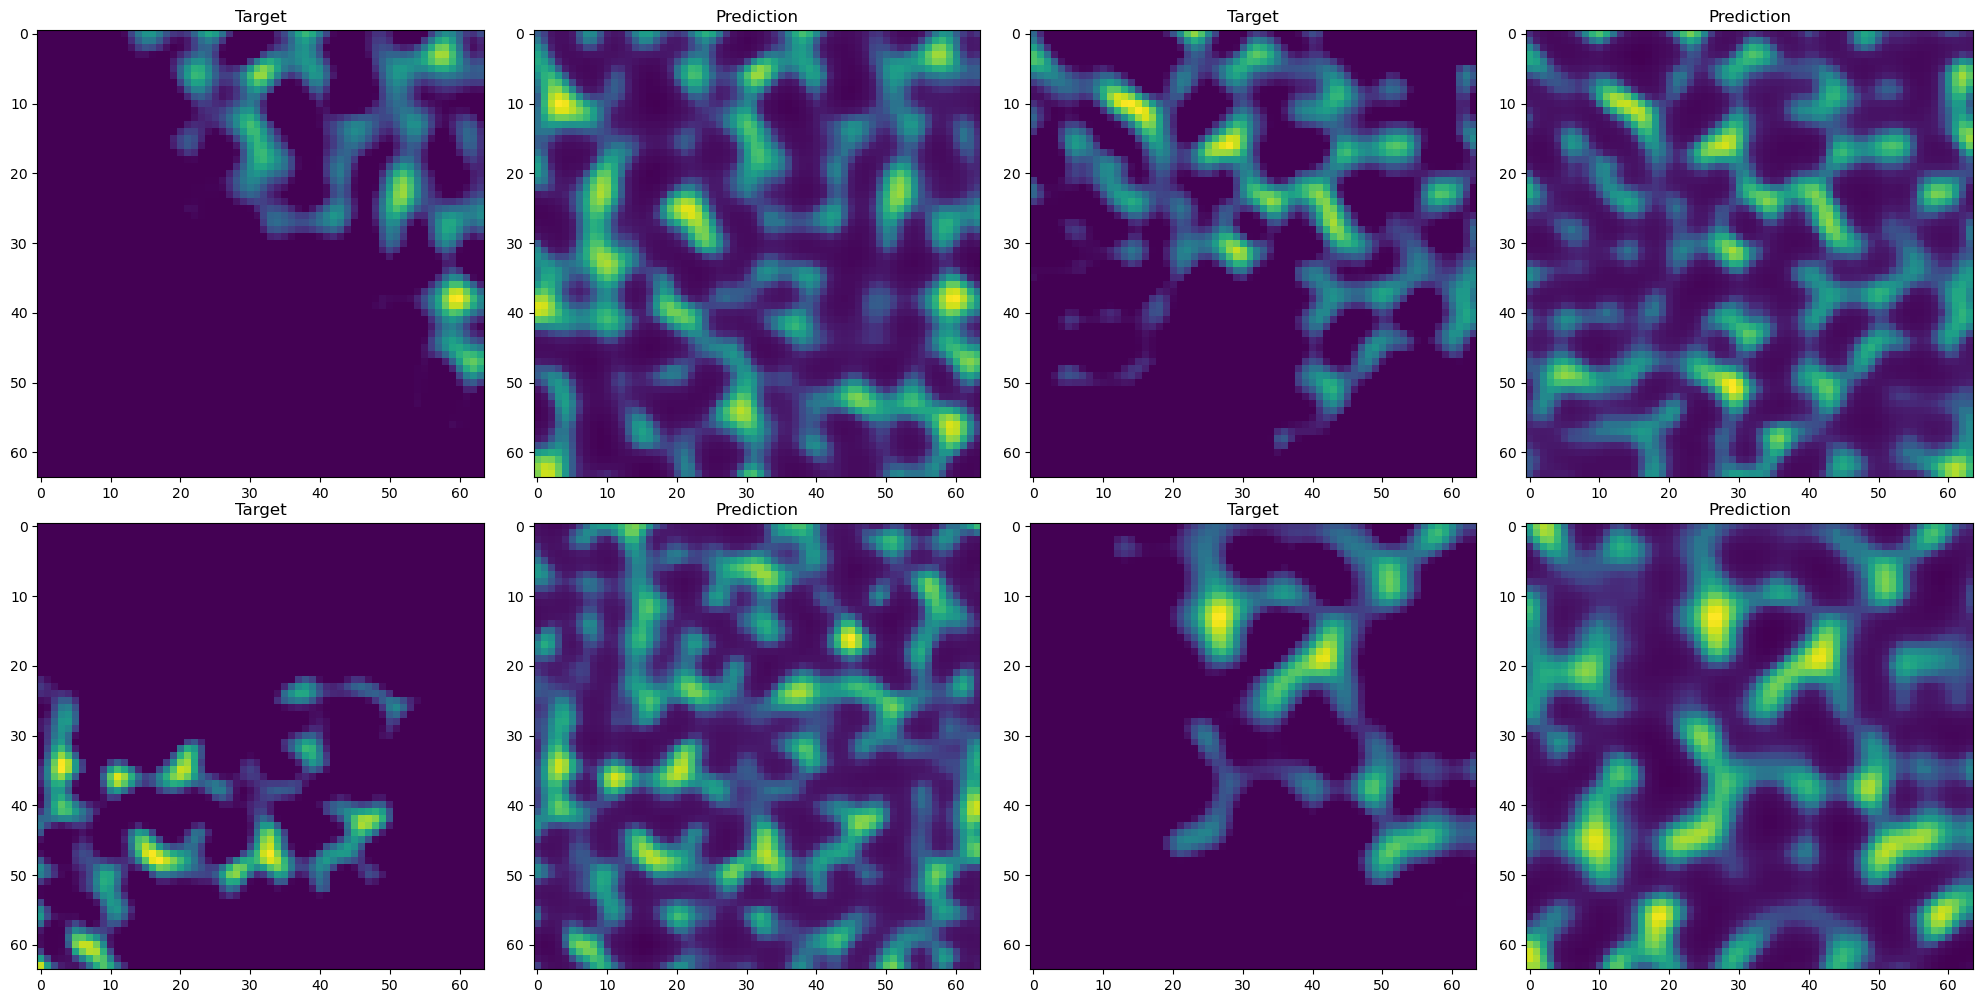

In [15]:
model.eval()

grid_size = 64
channels = 2

f,axs = plt.subplots(2, 4, figsize=(20,10))
axs = axs.reshape(-1)

for i in range(0, len(axs), 2):
  with torch.no_grad():
      # Randomly select a simulation
      sim = WaterTopo.load_simulations(str(root)+"/data/normalized_data/tra_val", 
                                       1, 
                                       grid_size, 
                                       use_augmented_data)[0]

      inputs = np.zeros((grid_size, grid_size, channels))
      targets = np.zeros((grid_size, grid_size))
    
      inputs[:,:,0] = get_corner(sim.wd[0])
      inputs[:,:,1] = sim.topography
      targets[:,:,] = sim.return_timestep(-1)

      # inputs, target = inputs.to(device).unsqueeze(0), target.to(device).unsqueeze(0)

      # Predict
      inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
      prediction = model(inputs).cpu()

      # Plotting inputs (time series)
      axs[i].imshow(targets)
      axs[i+1].imshow(prediction)

      axs[i].set_title(f"Target")
      axs[i+1].set_title(f"Prediction")

f.tight_layout()